In [1]:
from music21 import midi, note, interval, pitch, serial, stream, instrument, meter, key, converter, scale, graph
import itertools
import random

import scipy.io.wavfile as wave
from IPython.display import Audio

# Euphoria

## General description

For this part, the generation process will begin as follows: we will first generate an acylic directed graph where nodes will represent a certain chord/scale over which the instruments will play, and the edges will represent possible transitions from one chord/scale to another; their weight will represent a score that will influence the probability of transition --- the calculations will be further detailed below. Then, from this generated graph, we will try to find a path from the beginning to the end node that minimizes the total weight of the path (shortest path); we will use Dijkstra's algorithm for this.

We believe that it can be potentially very interesting to let random algorithms to decide this part, because, although our influence over them with some more traditional structures, they will allow to maybe introduce unexpected borrowed chords or intermodal changes --- and such random events will bring us closer to the partial instability/incoherence of a dream. We had thought of just taking random chords, but that produced structures that we would qualify as unpleasant to the ear and most importantly inconsistent with the idea of this part.

The palette of chords and scales will be chosen such that the possible generated progression will match the emotion (*i.e.* euphoria, delirium). To be more precise, we will use: major seven chords, lydian (suspended) chords for a more heavenly feel, minor seventh chords, dominant seventh chords for a more psychedelic feel (v minor to I major, *e.g.* from Em(7) to AMaj(7)). We had thought of scales/modes that are much less used for this genre/emotion, such a whole-tone scale, but we believe that those didn't bring the desired feeling.

To arrange this section, in the end, we will use the generated progression with the given arpeggios (see below) played by a highly processed guitar namely with flangers/phasers, reverbs and delays; we will layer this sound with more passive arrangements (*i.e.* that will mostly just play the chord) of strings, winds and some Mellotron sounds (all less heavily processed) to add a more floating feel to this part. Moreover, for the melody, we will manually compose a quite "empty" melody (in the sense that it will contain not that much notes) for probably a lead guitar. We choose to do this without algorithms, because, since the chord progression will be potentially quite difficult to follow already, algorithms that we might use would produce either a too random or a *too* empty sound; we would also like to see how well the structure generated can lead human creativity.

### How to generate the graph?

Let us first state the different steps (numbered) so we can more easily follow the underlying code:

1. Create a 1st node with a random chord/scale by first picking one of the chords/scales from the palette, and then picking a random tonic (to transpose the the chosen item);
2. Then, at each level, we will create the same amount of $n$ nodes, by splitting them into two groups of equal size ($n/2$): the first group will have random tonics; the second group will have tonics that are either related to the 1st node by the circle of fifths (so it is either its fifth or the other way around), or another random diatonic chord with respect to the very first tonic; both groups will take random chords/scales from the palette;
3. Once a level is generated, connect the two node levels (the previous one to the new one) with weighted edges, of which the weight is calculated by the formula described just after this;
4. Repeat this step until $k$ (a parameter) stages are generated, and connect all nodes to a final one, whose chord will be irrelevant, since we will choose it so that this part is resolved (perfect cadence, back to I maj).

As promised, the formula to calculate the weight from a node of a level to a node of the next one is: $$weight(u, v) = \begin{cases}\max(0, 12 - \lvert tonesInCommon(u, v)\rvert) &\text{if the tonic of } v \text{ is not in } u \\ \max(0, 12 - \lvert tonesInCommon(u, v)\rvert + 3) &\text{otherwise} \end{cases}$$
(NB: $u, v$ are also the scales of the nodes.)
It is of course arbitrary and quite simple, but, after multiple tests of more complex formulas, we believe it yields quite interesting results. For instance, when we tried to include the interval between the tonics, we saw that it penalized too much intermodal change, which can produce interesting sounds. We have also tried using inverses, but and other techniques, but they usually took *exclusively* chords based on notes of the scale (so only diatonic chords). This formula usually gave us good resulsts, by *mostly* taking such diatonic chords, but also adding some randomness. (The $+3$ allows this.) Note, again, that this formula is purely empirical.

Let's get to the code now!

## Code

## First, some utils

(Some were taken from previous notebooks of this class.)

In [2]:
def play(stream):
    """Shortcut to play a stream"""
    midi.realtime.StreamPlayer(stream).play()

def from_part_to_collection(part):
    """From a stream.Part creates a collection of events (mostly notes, time signatures)."""
    ret = []
    for elem in part.flat:
        if type(elem) == note.Note or type(elem) == meter.TimeSignature:
            ret.append(elem)
    return ret

def from_collection_to_part(notes):
    """
    From a collection of events, creates a stream. This method with `from_part_to_collection`
    allows to easily combine two parts.
    """
    st = stream.Stream()
    for note in notes:
        st.append(note)
    return st

def combine_parts(left, right):
    a = from_part_to_collection(left)
    b = from_part_to_collection(right)
    whole = a + b
    return from_collection_to_part(whole)

In [3]:
allNotes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

def random_note():
    """Returns a random note."""
    return allNotes[random.randint(0, len(allNotes) - 1)]

def fifth_of(note):
    return transpose_note(note, 7)

def interval_semitones(start, end):
    """
    Returns the interval in semi-tones between the two notes, starting at
    `start` and ending at `end`.
    """
    a = start
    b = end
    if type(start) == pitch.Pitch:
        a = start.name
    if type(end) == pitch.Pitch:
        b = end.name
    return allNotes.index(b) - allNotes.index(a)

def transpose_note(note, semiTones):
    """
    Transposes the provided note.
    """
    n = note
    if type(note) == pitch.Pitch:
        n = note.name
    return allNotes[(allNotes.index(n) + semiTones) % len(allNotes)]

def transpose_collection(notes, semiTones):
    """
    Transposes the collection of notes by the given amount of semi-tones.
    """
    return [transpose_note(note, semiTones) for note in notes]

def transpose(st, oldTonic, newTonic):
    """Transposes the provided stream to the new tonic."""
    ot = oldTonic
    nt = newTonic
    if type(ot) != pitch.Pitch:
        ot = pitch.Pitch(ot)
    if type(nt) != pitch.Pitch:
        nt = pitch.Pitch(nt)
    i = interval.Interval(ot, nt)
    ret = st.transpose(i)
    return ret

In [14]:
class Scale:
    
    # Note: we are aware of the existence of the music21's Scale class.
    # We just needed something more specialized, that contained less features.
    
    def __init__(self, func, tonic, notes, arp):
        self.func = func
        self.tonic = tonic
        self.notes = notes
        self.arp = arp
        
    def transposed(self, newTonic):
        nt = newTonic
        if type(newTonic) == pitch.Pitch:
            nt = newTonic.name
        inter = interval_semitones(self.tonic, nt)
        newArp = transpose(self.arp, self.tonic, nt)
        return Scale(
            self.func,
            pitch.Pitch(transpose_note(self.tonic, inter)),
            transpose_collection(self.notes, inter),
            newArp
        )
    
    def __repr__(self):
        return self.__str__()
    
    def __str__(self):
        return self.tonic.name + ' ' + self.func
    
    def __eq__(self, other):
        if type(other) != Scale:
            return False
        return self.tonic == other.tonic and self.func == other.func


The palette of arpeggios:

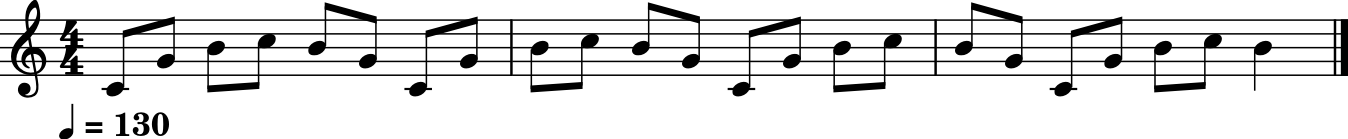

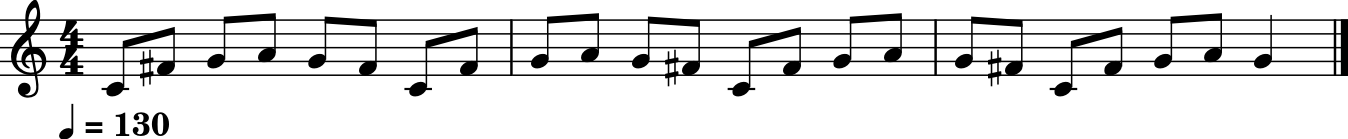

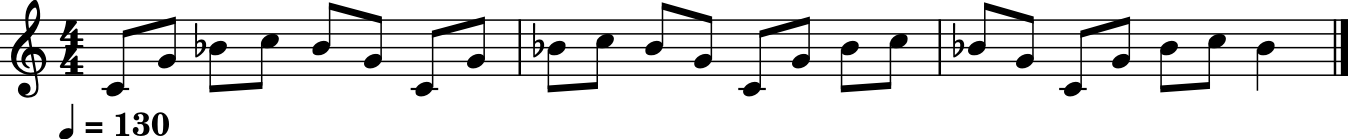

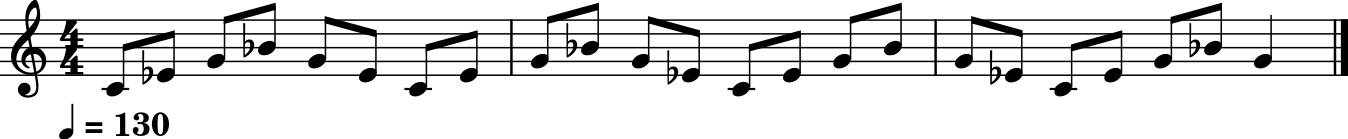

In [5]:
# This is a sample arpeggio over the C major seven chord
arpMajSev = converter.parse('midi/ARP_00_CMaj7.mid')[0]
arpMajSev.insert(0, instrument.Piano())
arpMajSev.show()
# This is an arpeggio over the C major lydian (suspended) chord
# (i.e. instead of playing a sus4, we raise the 4th tone by a half tone,
# so it is playing over C lydian). Also note the sixth (A).
arpLydSus = converter.parse('midi/ARP_01_CLydSus.mid')[0]
arpLydSus.insert(0, instrument.Piano())
arpLydSus.show()
# Arpeggio over the C7 chord
arpDomSev = converter.parse('midi/ARP_02_C7.mid')[0]
arpDomSev.insert(0, instrument.Piano())
arpDomSev.show()
# Arpeggio over the Cmin7 chord
arpMinSev = converter.parse('midi/ARP_03_Cmin7.mid')[0]
arpMinSev.insert(0, instrument.Piano())
arpMinSev.show()

The palette of scales itself:

In [31]:
def create_palette():
    # By default, all scales are just modes with C as a tonic, but of course
    # it will be transposed, etc.; this is just to use "C" as a neutral element,
    # if notes were an algebra.
    
    ret = []
    # major/ionian
    cMaj = ['C', 'D', 'E', 'F', 'G', 'A', 'B']
    # lydian
    cLyd = ['C', 'D', 'E', 'F#', 'G', 'A', 'B']
    # minor/aeolian
    cMin = ['C', 'D', 'D#', 'F', 'G', 'G#', 'A#']
    # mixolydian
    cMyx = ['C', 'D', 'D#', 'F', 'G', 'A', 'A#']
    # add
    pitchC = pitch.Pitch('C')
    ret.append(Scale('major', pitchC, cMaj, arpMajSev))
    ret.append(Scale('lydian', pitchC, cLyd, arpLydSus))
    ret.append(Scale('mixolydian', pitchC, cMyx, arpDomSev))
    ret.append(Scale('minor', pitchC, cMin, arpMinSev))
    dictionnary = dict()
    for scale in ret:
        dictionnary[scale.func] = scale
    return ret, dictionnary


def random_quasi_diatonic(orig):
    """
    Returns a scale based on a chord that's diatonic with respect to provided scale.
    Note that the notes of the created scale will be different (the root cannot be selected, 
    neither can be the 7th degree.)
    """
    deg = random.randint(1, len(orig.notes) - 2)
    tonic = orig.notes[deg] # Here, we exclude the last tone to exclude the 7th degree of the scale
    ret = None
    # note that the following indices are one below than what they usually are
    # e.g. the 2nd degree is 1
    if deg == 1:
        ret = palette_dictionnary['minor']
    elif deg == 2:
        ret = palette_dictionnary['minor']
    elif deg == 3:
        ret = palette_dictionnary['lydian']
    elif deg == 4:
        ret = palette_dictionnary['mixolydian']
    elif deg == 5:
        ret = palette_dictionnary['minor']
    return ret.transposed(tonic)

def random_scale_from_palette():
    return palette[random.randint(0, len(palette) - 1)]

palette, palette_dictionnary = create_palette()
print(palette)

[C major, C lydian, C mixolydian, C minor]


## Creating the graph

In [7]:
# We will use networkx for the graphs and matplotlib for the visual representations
import networkx as nx
import matplotlib.pyplot as plt

In [63]:
def calculate_score(a, b):
    """
    Calculates the score between two scales. (See above for the description.)
    a: Scale
    b: Scale
    """
    notesA = a.notes
    notesB = b.notes
    m = 12 - max(1, len(set(notesA) & set(notesB)))
    if b.tonic.name in a.notes:
        m += 3
    return max(0, m)

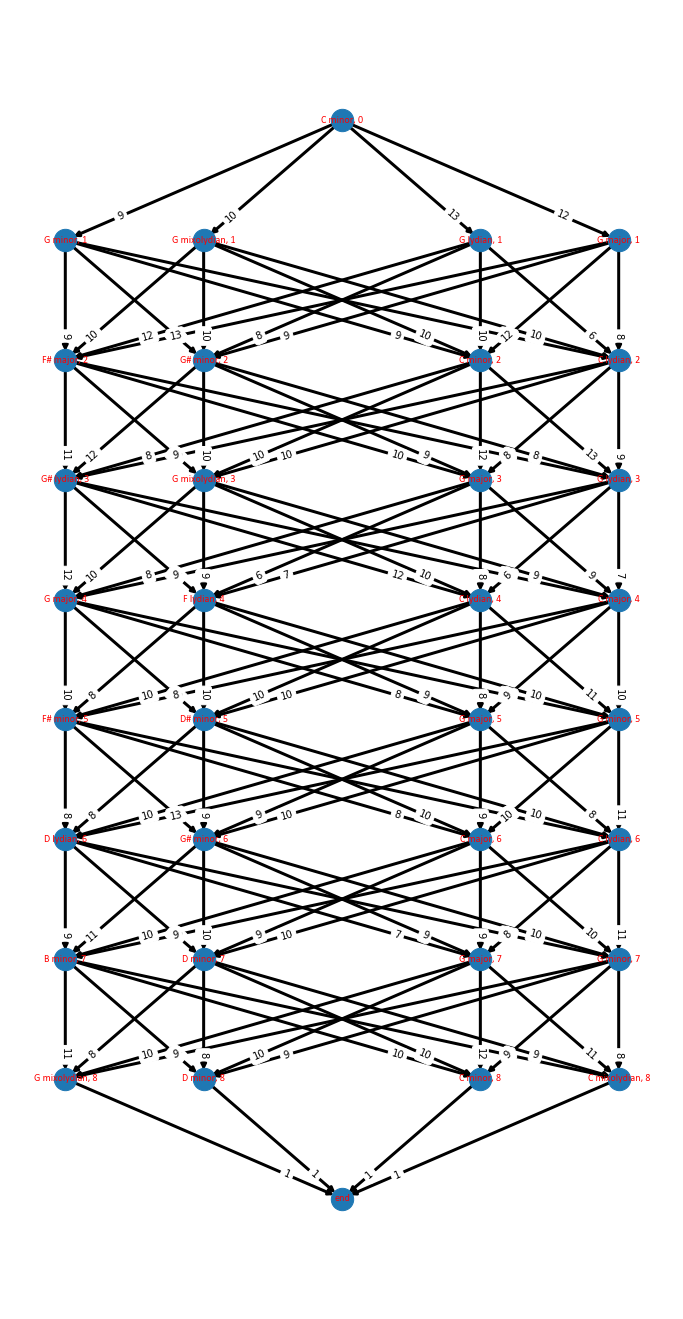

[C minor,
 G lydian,
 C lydian,
 G major,
 F lydian,
 F# minor,
 C lydian,
 G major,
 D minor]

In [67]:
import sys # for maxsize

def node_name(scale, level):
    return str(scale) + ', ' + str(level)

def scale_from_graph_name(parse):
    first = parse.split(', ')[0]
    note_mode = first.split(' ')
    return palette[palette.index(Scale(note_mode[1], pitch.Pitch('C'), None, None))].transposed(note_mode[0])

def generate_progression(tonic, levels, n):
    # create a dictionary of positions (this will allow a better display in networkx)
    positions = dict()
    # generate the first node
    # I had never noticed that the upperbound was a possible result in Python :') (hence the - 1)
    first_scale = random_scale_from_palette().transposed(tonic)
    # create the graph
    graph = nx.DiGraph()
    # this will be reset at each iteration
    prev_level = [first_scale]
    allLevels = [prev_level]
    positions[node_name(first_scale, 0)] = (0, 0)
    
    fifth = fifth_of(tonic)
    for i in range(1, levels + 1):
        current_level = []
        for k in range(0, n // 2):
            new = None
            # generate a new node
            while new == None or new in current_level:
                if k % 2 == 0:
                    new = random_quasi_diatonic(first_scale)
                else:
                    new = random_scale_from_palette().transposed(random_note())
            current_level.append(new)
            name = node_name(new, i)
            # add the node
            positions[name] = (-(k + 1) * 2, -i)
            graph.add_node(name)
        for k in range(0, n // 2):
            new = None
            # generate a new node
            while new == None or new in current_level:
                new = random_scale_from_palette().transposed(fifth)
            current_level.append(new)
            name = node_name(new, i)
            # add the node
            positions[name] = ((k + 1) * 2, -i)
            graph.add_node(name)
        # connect with the previous level
        for prev in prev_level:
            for curr in current_level:
                graph.add_edge(node_name(prev, i - 1), node_name(curr, i), weight = calculate_score(prev, curr))
        
        allLevels.append(current_level)
        prev_level = current_level
        # switch between tonic and fifth
        if fifth == tonic:
            fifth = fifth_of(tonic)
        else:
            fifth = tonic

    # add final node
    final_level = "end"
    graph.add_node(final_level)
    positions[final_level] = (0, - levels - 1)
    
    for e in prev_level:
        graph.add_edge(node_name(e, levels), final_level, weight = 1)
    
    # Apply Dijkstra        
    dj = nx.algorithms.shortest_paths.weighted.dijkstra_path(graph, node_name(first_scale, 0), final_level)
    
    plt.figure(3, figsize=(12, 24))
    # nodes
    nx.draw_networkx_nodes(graph, positions, node_size=500)

    # edges
    nx.draw_networkx_edges(graph, positions, width=3, arrows=True)

    # labels
    nx.draw_networkx_labels(graph, positions, font_size=10, font_family="calibri", font_color="#ff0000")
    weights = nx.get_edge_attributes(graph, 'weight')
    nx.draw_networkx_edge_labels(graph, positions, edge_labels=weights, label_pos=0.2)
    
    plt.axis("off")
    plt.show()
    return dj
path = generate_progression(pitch.Pitch('C'), 8, 4)
[scale_from_graph_name(x) for x in path if x != "end"]

(The above is only an instance of the algorithm.)

To conclude, we will add a major chord over the first tonic to feel the "happy" resolution.